<a href="https://colab.research.google.com/github/rira0526/dti_py/blob/main/segmentation_models_pytorch_VOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インポート

In [1]:
# 必要なライブラリのinstall
%%capture
!pip install opencv-python-headless==4.1.2.30
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install segmentation-models-pytorch==0.2.1

In [2]:
import os
import tarfile
import urllib.request

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torch.utils.data as data
from PIL import Image

# VOCデータのDL

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# 使用データのDL
data_dir = "/gdrive/MyDrive/zikken3/multiclass segmentation"
if not os.path.exists(data_dir):
    print("data_dir not exitst")
    os.mkdir(data_dir)

# url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
# target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

# if not os.path.exists(target_path):
#     urllib.request.urlretrieve(url, target_path)
#     tar = tarfile.TarFile(target_path)
#     tar.extractall(data_dir)
#     tar.close()

# augmentation、前処理関連の関数定義

In [5]:
def get_augmentation(phase):
    if phase == "train":
        train_transform = [
            albu.HorizontalFlip(p=0.5),
            albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
            albu.RandomBrightnessContrast()
        ]
        return albu.Compose(train_transform)

    if phase=="valid":
        return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def crop_to_square(image):
    size = min(image.size)
    left, upper = (image.width - size) // 2, (image.height - size) // 2
    right, bottom = (image.width + size) // 2, (image.height + size) // 2
    return image.crop((left, upper, right, bottom))

# Datasetの定義

In [6]:
class VOCDataset(data.Dataset):

    # VOCデータセットのクラス名
    # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html
    CLASSES = ["background","nerve","spinal"]

    def __init__(self, images_path, masks_path, segment_class, 
                 augmentation=None, preprocessing=None):

        self.images_path = images_path
        self.masks_path = masks_path
        self.segment_class = segment_class
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, i):

        # 元画像の読み込み、整形
        image = Image.open(self.images_path[i])
        image = crop_to_square(image)
        image = image.resize((128,128), Image.ANTIALIAS)
        image = np.asarray(image)

        # maskの読み込み、整形
        
        masks = Image.open(self.masks_path[i])
        masks = crop_to_square(masks)
        masks = masks.resize((128,128), Image.ANTIALIAS)
        masks = np.asarray(masks)

        # maskデータの境界線を表す255は扱いにくいので21に変換
        masks = np.where(masks == 255, 21, masks)

        # maskデータを正解ラベル毎の1hotに変換
        cls_idx = [self.CLASSES.index(cls) for cls in self.segment_class]
        masks = [(masks == idx) for idx in cls_idx]
        mask = np.stack(masks, axis=-1).astype("float")

        # augmentationの実行
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # 前処理の実行
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

# モデル定義

In [21]:
# モデルの各種設定
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax2d"
PREDICT_CLASS = ["background", "nerve", "spinal"]
DEVICE = "cuda"
BATCH_SIZE = 8

# Unet++でモデル作成
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(PREDICT_CLASS), 
    activation=ACTIVATION,
)

# モデリングで使用するデータ周りの作成

In [22]:
import glob
# encoderに合わせた前処理の取得
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
train_img_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/images/training/*.png")
train_mask_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/annotations/training/*.png")
val_img_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/images/validation/*.png")
val_mask_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/annotations/validation/*.png")
# データ周りを格納する辞書
data_info = {}
rootpath = r"/gdrive/MyDrive/zikken3/multiclass segmentation"

for phase in ["train", "val"]:
    # 画像のpath
    id_names = rootpath + rf"ImageSets/Segmentation/{phase}.txt"
    exec_command = 'data_info[f"{phase}_img_path"] = ' + str(phase) + '_img_file'
    exec(exec_command)
    exec_command = 'data_info[f"{phase}_mask_path"] = ' + str(phase) + '_mask_file'
    exec(exec_command)

    # print(data_info["train_img_path"][0])


    
    # data_info[f"{phase}_img_path"] = [rootpath + rf"JPEGImages/{file.strip()}.jpg" for file in open(id_names)]
    # data_info[f"{phase}_mask_path"] = [rootpath + rf"SegmentationClass/{file.strip()}.png" for file in open(id_names)]

    # Dataset
    data_info[f"{phase}_dataset"] = VOCDataset(
            data_info[f"{phase}_img_path"], 
            data_info[f"{phase}_mask_path"], 
            segment_class=PREDICT_CLASS,
            augmentation=get_augmentation(phase), 
            preprocessing=get_preprocessing(preprocessing_fn)
            )

    # DataLoader
    shuffle = True if phase=="train" else False
    data_info[f"{phase}_dataloader"] = data.DataLoader(
        data_info[f"{phase}_dataset"], 
        batch_size=BATCH_SIZE, 
        shuffle=shuffle)

In [23]:
print(len(data_info["train_img_path"]))
print(len(data_info["train_mask_path"]))
print(len(data_info["val_img_path"]))
print(len(data_info["val_mask_path"]))

537
537
131
131


In [24]:
# import glob
# data_info = {}
# training_img_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/images/training/*.png")
# training_mask_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/annotation/training/*.png")
# validation_image_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/images/validation/*.png")
# validation_mask_file = glob.glob(f"/gdrive/MyDrive/zikken3/multiclass segmentation/annotation/validation/*.png")
# # print(t[0])
# for i in range(len(training_img_file)):
#   data_info["train_img_path"][i] = training_img_file[i]
#   data_info["train_mask_path"][i] = training_mask_file[i]

# for i in range(len(validation_image_file)):
#   data_info[f"val_img_path"][i] = validation_image_file[i]
#   data_info[f"val_mask_file"][i] = validation_mask_file[i]



# 学習の設定、実行

In [25]:
# 学習時の各種設定
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE
)

In [26]:
patience = 5 # 5Epcoch以上連続でモデル精度が向上しなければEarly Stopping

max_score = 0
for i in range(50):
    
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(data_info["train_dataloader"])
    valid_logs = valid_epoch.run(data_info["val_dataloader"])
    
    # IoUスコアが最高値が更新されればモデルを保存
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, "./best_model.pth")
        print("Model saved!")
        early_stop_counter = 0

    else:
        early_stop_counter += 1
        print(f"not improve for {early_stop_counter}Epoch")
        if early_stop_counter==patience:
            print(f"early stop. Max Score {max_score}")
            break

    # 適当なタイミングでlearning rateの変更
    if i == 10:
        optimizer.param_groups[0]["lr"] = 1e-5
        print("Decrease decoder learning rate to 1e-5")


Epoch:1
valid: 100%|██████████| 17/17 [00:01<00:00, 10.81it/s, dice_loss - 0.3782, iou_score - 0.6713]
Model saved!
Epoch:2
valid: 100%|██████████| 17/17 [00:01<00:00, 10.87it/s, dice_loss - 0.215, iou_score - 0.8802]
Model saved!
Epoch:3
valid: 100%|██████████| 17/17 [00:01<00:00, 11.11it/s, dice_loss - 0.1009, iou_score - 0.9806]
Model saved!
Epoch:4
valid: 100%|██████████| 17/17 [00:01<00:00, 11.19it/s, dice_loss - 0.0725, iou_score - 0.9933]
Model saved!
Epoch:5
valid: 100%|██████████| 17/17 [00:01<00:00, 11.12it/s, dice_loss - 0.04951, iou_score - 0.9941]
Model saved!
Epoch:6
valid: 100%|██████████| 17/17 [00:01<00:00, 11.27it/s, dice_loss - 0.03994, iou_score - 0.9941]
Model saved!
Epoch:7
valid: 100%|██████████| 17/17 [00:01<00:00, 11.33it/s, dice_loss - 0.02603, iou_score - 0.9941]
not improve for 1Epoch
Epoch:8
valid: 100%|██████████| 17/17 [00:01<00:00, 10.97it/s, dice_loss - 0.02291, iou_score - 0.9941]
not improve for 2Epoch
Epoch:9
valid: 100%|██████████| 17/17 [00:01<00:0

# 推論と可視化による検証

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FE54FDFA3B0>


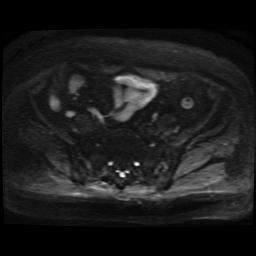

In [27]:
# モデルのロード
best_model = torch.load("./best_model.pth")
best_model.eval()

# 可視化用のpalette取得
image_sample_palette = Image.open(data_info["val_img_path"][0])
print(image_sample_palette)
image_sample_palette.show()
PALETTE = image_sample_palette.getpalette()

In [35]:
# 検証データから"cat","person"を含む画像を取得
idx_dict = {"nerve":[],"spinal":[],"both":[]}

# 該当の対象物があればpathをリストに加える
for i, path in enumerate(data_info["val_mask_path"]):

    img = np.asarray(Image.open(path))
    unique_class = np.unique(img)

    if 8 in unique_class and 15 in unique_class:
        idx_dict["both"].append(i)
        
    elif 8 in unique_class:
        idx_dict["nerve"].append(i)
        
    elif 15 in unique_class:
        idx_dict["spinal"].append(i)

In [36]:
# 検証用の関数を作成
def check_prediction(n):

    # 前処理後の画像とmaskデータを取得
    img, mask = data_info["val_dataset"][n]

    fig, ax = plt.subplots(1, 3, tight_layout=True)
    
    # 前処理後の画像を表示
    ax[0].imshow(img.transpose(1,2,0))

    # DataloaderのmaskはOne-Hotになっているので元に戻してパレット変換
    mask = np.argmax(mask, axis=0)
    mask = Image.fromarray(np.uint8(mask), mode="P")
    mask.putpalette(PALETTE)
    ax[1].imshow(mask)

    # 推論結果の表示    
    x = torch.tensor(img).unsqueeze(0) # 推論のためミニバッチ化：torch.Size([1, 3, 128, 128])

    # 推論結果は各maskごとの確率、最大値をその画素の推論値とする
    y = best_model(x.to(DEVICE))
    y = y[0].cpu().detach().numpy()
    y = np.argmax(y, axis=0)

    # パレット変換後に表示
    predict_class_img = Image.fromarray(np.uint8(y), mode="P")
    predict_class_img.putpalette(PALETTE)
    ax[2].imshow(predict_class_img)

    plt.show()

In [37]:
# ラベル毎に実行して結果を確認
for label, idx_list in idx_dict.items():
    print("="*30 , label, "="*30)
    for i, idx in enumerate(idx_list):
        check_prediction(idx)
        if i==2:
            break

============================== nerve ==============================
============================== spinal ==============================
============================== both ==============================
